# Simulation of the particle-magnet magnetic interation

## System description

In the Water Treatment Plants (WTP), The remaining microplastic residues will be captured by structures combined with encapsulin and plastic-binding proteins (PBPs), which will have magnetic nanoparticles inside. This complex will be called MPBE-MP. After this capture, the MPBE-MP will be directed to an alternative path using an external magnetic field, generated by a magnet.

## Objectives

The aim of the simulation is to demonstrate the functioning of the system, given the respective physical values of reality.

## Metodology

- Create a class to the MPBE-$\mu$P
- Add in the arguments to instantiate the class, characteristics such as the magnetic dipole moment, the mass of the MPBE-$\mu$P and the initial position in $\hat{z}$.
- Add other properties of the class, such as acceleration and the initial speed of the MPBE-$\mu$P in $\hat{z}$.
- Add a movement method to the MPBE-$\mu$P class.
- Create a class to the system
- Add in the arguments to instantiate the class, characteristics such as magnetic field, water flow speed, water viscosity and pipe size.
- Create a system update method in the System class.
- Create an ilustration using MatplotLib

In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import imageio
from tqdm import tqdm

In [2]:
def draw_particles(ax, particle_list):
    particle_number = len(particle_list)
    circle = [None]*particle_number
    for i in range(particle_number):
        circle[i] = plt.imshow(particle_list[i].image, extent=(particle_list[i].position[0] - particle_list[i].radius, particle_list[i].position[0] + particle_list[i].radius, particle_list[i].position[1] - particle_list[i].radius, particle_list[i].position[1] + particle_list[i].radius))
        mpbe_position = (particle_list[i].position[0] + np.random.choice([-1, -0.5, 0, 0.5, 1]), particle_list[i].position[1] + np.random.choice([-1, -0.5, 0, 0.5, 1]))
        circle2 = plt.imshow(particle_list[i].image2, extent=(mpbe_position[0] - 2, mpbe_position[0] + 2, mpbe_position[1] - 2, mpbe_position[1] + 2))
        
def choose_index(matrix):
    # Find indices where the element is 0
    zero_indices_i, zero_indices_j = np.where(matrix == 0)
    
    # Check if there are any 0 elements in the array
    if len(zero_indices_i) > 0:
        # Choose a random index from the zero_indices
        u = np.random.randint(0, len(zero_indices_i))
        return (zero_indices_j[u], zero_indices_i[u])
    else:
        return False
        

class MPBE_uP:
    def __init__(self, u, m, x0, y0, r, img_ind):
        self.magnetic_moment = u
        self.mass = m
        self.position = np.array([x0, y0])
        self.velocity = np.array([0, 0])
        self.image = mpimg.imread(f'Images/microplastics_images/mp{img_ind}.png')
        self.image2 = mpimg.imread(f'Images/mpbe.png')
        self.radius = r
        
    def forces(self, magnet_position, mag_dip_magnet, viscosity):
        d = np.linalg.norm(self.position - magnet_position)
        magnetic_force_r = -self.magnetic_moment*mag_dip_magnet/(d**3)
        dx = self.position[0] - magnet_position[0]
        magnetic_force = (dx/d)*magnetic_force_r
        viscosity_force = -viscosity*(self.velocity**2)
        
        resultant_force = magnetic_force + viscosity_force
        
        return resultant_force
    
    def update_velocities(self, dt, magnet_position, mag_dip_magnet, viscosity):
        F = self.forces(magnet_position, mag_dip_magnet, viscosity)
        self.velocity = self.velocity + (F/self.mass)*dt
        if self.position[0] < self.radius:
            self.velocity[0] = 0
        return
    
    def __add__(self, dt):
        self.position = self.position + self.velocity*dt
        return
    


class System:
    def __init__(self, N_1, V, m_x, m_y, u, u_p, m_p, vis, r):
        self.magnet_position = np.array([m_x, m_y])
        self.mag_dip_magnet = u
        self.viscosity = vis
        self.proportion = np.int(np.sqrt(V)/12)
        self.height = self.proportion*8
        self.image_height = self.proportion*9
        self.width = self.proportion*16
        self.particle_radius_1 = r
        self.particles = []
        self.number_of_particles_1 = N_1
        self.particle_mass = m_p
        self.particle_dipole_moment = u_p
            
        # Load the background image
        self.background_image = mpimg.imread('Images/background.png')
        
        occupied_positions_1 = np.zeros((self.height, self.width))
        occupied_positions_1[0: self.particle_radius_1, :] = 1
        occupied_positions_1[self.height - self.particle_radius_1: self.height, :] = 1
        occupied_positions_1[:, 0:self.particle_radius_1] = 1
        occupied_positions_1[:, self.width - self.particle_radius_1: self.width] = 1
        
        for ind_vel in range(self.number_of_particles_1):
            # Initial position selection
            x_generation, y_generation = choose_index(occupied_positions_1)
            occupied_positions_1[(x_generation-2*self.particle_radius_1):(x_generation+2*self.particle_radius_1), (y_generation-2*self.particle_radius_1):(y_generation+2*self.particle_radius_1)] = 1
            
            # Particle creation
            IMAGE_INDEX = np.random.randint(1, 6)
            particle = MPBE_uP(self.particle_dipole_moment, self.particle_mass, x_generation, y_generation, self.particle_radius_1, IMAGE_INDEX)
            self.particles.append(particle)
        
        self.particle_positions = {"Initial": [0]}
        for i, particle in enumerate(self.particles):
            self.particle_positions[f'particle {i}'] = [particle.position]
        
    def main(self, dt, frame_period, n):
        
        fig = plt.figure(figsize=(16, 9))
        ax = fig.add_subplot(1, 1, 1)
        
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        ax.set_xlim([0,self.width])
        ax.set_ylim([0,self.image_height])
        
        ax.imshow(self.background_image, extent=[0, self.width, 0, self.image_height])
        
        draw_particles(ax, self.particles)
        
        plt.savefig(f'./GIF - magnet simulation/Image {n}.jpg', 
                transparent = False,  
                facecolor = 'white'
               )
        plt.close()
        
        for _ in range(frame_period):
            for particle in self.particles:
                particle + dt
                particle.update_velocities(dt, self.magnet_position, self.mag_dip_magnet, self.viscosity)
                
        for i, particle in enumerate(self.particles):
            self.particle_positions[f'particle {i}'] = [particle.position]


C:\Users\GABRIE~1\AppData\Local\Temp/ipykernel_28320/3810450933.py:61: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  self.proportion = np.int(np.sqrt(V)/12)
  2%|█▋                                                                                | 5/250 [00:20<16:39,  4.08s/it]


KeyboardInterrupt: 

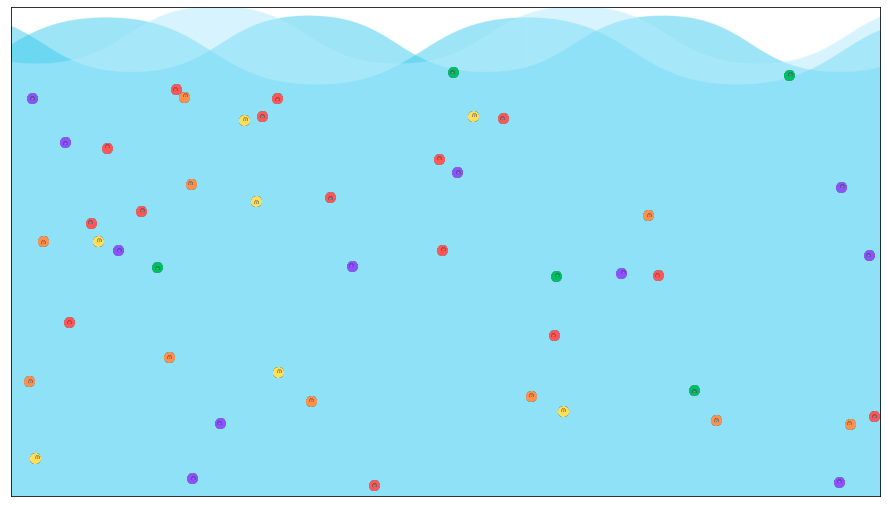

In [3]:
PARTICLES_NUMBER = 50
VOLUME = 360000
MAGNET_POSITION = (0, 50)
MAGNETIC_DIPOLE_MAGNET = 100000
MAGNETIC_DIPOLE_MPBE = 100
MPBE_MASS = 0.05
WATER_VISCOSITY = 1
MPBE_MP_RADIUS = 5


Particles_system = System(PARTICLES_NUMBER, VOLUME, MAGNET_POSITION[0], MAGNET_POSITION[1], MAGNETIC_DIPOLE_MAGNET, MAGNETIC_DIPOLE_MPBE, MPBE_MASS, WATER_VISCOSITY, MPBE_MP_RADIUS)

N = 250

for i in tqdm(range(N)):
    Particles_system.main(0.005, 1, i)

In [ ]:
frames = []
for i in range(N):
    image = imageio.imread(f'./GIF - magnet simulation/Image {i}.jpg')
    frames.append(image)

In [ ]:
imageio.mimsave('./magnet_simulation.gif', # output gif
                frames,          # array of input frames
                duration = 0.1)         # optional: frames per second

In [ ]:
from IPython.display import display, Image

display(Image(filename='magnet_simulation.gif'))